# Описание проекта

Клиентам предлагают два тарифных плана:
    «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, **какой тариф приносит больше денег**.
    Необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»:
    кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод, какой тариф более выгодно рекламировать.

## План работы
* Изучить общую информацию о данных
* Обработать данные (изменить тип, устранить пропуски, выявить прочие проблемы)
* Сравнить потребительское поведение пользователей тарифов `Smart` и `Ultra`
* Посчитать выручку по каждому абоненту
* Сравнить средние выручки по разным группам абонентов (по тарифу и по городу)


In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import seaborn as sns
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [2]:
try:
    df_calls = pd.read_csv('calls.csv')
    df_internet = pd.read_csv('internet.csv')
    df_messages = pd.read_csv('messages.csv')
    df_tariffs = pd.read_csv('tariffs.csv')
    df_users = pd.read_csv('users.csv')
except:
    df_calls = pd.read_csv('/datasets/calls.csv')
    df_internet = pd.read_csv('/datasets/internet.csv')
    df_messages = pd.read_csv('/datasets/messages.csv')
    df_tariffs = pd.read_csv('/datasets/tariffs.csv')
    df_users = pd.read_csv('/datasets/users.csv')

In [3]:
df_calls.info()
display(df_calls)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


Выявленные проблемы с данными `df_calls`:
* В столбце `call_date` необходимо изменить тип данных на дату.
* В столбце `duration` необходимо округлить данные в большую сторону, поскольку по смыслу продолжительность звонков измеряется в минутах и неважно, сколько секунд поговорил абонент от минуты в тарфике она учитывается как целая.

In [4]:
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y.%m.%d')
df_calls['duration'] = np.ceil(df_calls['duration'])
df_calls['duration'] = df_calls['duration'].astype('int64')
df_calls['month'] = df_calls['call_date'].dt.month

In [5]:
df_internet.info()
display(df_internet)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...,...
149391,149391,1499_152,318.90,2018-10-03,1499
149392,149392,1499_153,490.13,2018-12-14,1499
149393,149393,1499_154,0.00,2018-10-27,1499
149394,149394,1499_155,1246.32,2018-11-26,1499


Выявленные проблемы с данными `df_internet`:
* В столбце `session_date` необходимо изменить тип данных на дату.
* Столбец `Unnamed: 0` просто дублирует индексацию, а значит его нужно удалить.
* Расход интернет трафика не стоит огруглять как в случае продолжительности звонков. Буду исходить из предположения, что за неполный ГБ интеренета абоненет будет платить стоимость пропортционально стоимости 1 ГБ.

In [6]:
df_internet = df_internet.drop(['Unnamed: 0'], axis=1)
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y.%m.%d')
df_internet['month'] = df_internet['session_date'].dt.month

In [7]:
df_internet

,id,mb_used,session_date,user_id,month
0,1000_0,112.95,2018-11-25,1000,11
1,1000_1,1052.81,2018-09-07,1000,9
2,1000_2,1197.26,2018-06-25,1000,6
3,1000_3,550.27,2018-08-22,1000,8
4,1000_4,302.56,2018-09-24,1000,9
...,...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499,10
149392,1499_153,490.13,2018-12-14,1499,12
149393,1499_154,0.00,2018-10-27,1499,10
149394,1499_155,1246.32,2018-11-26,1499,11


In [8]:
df_messages.info()
display(df_messages)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


Выявленные проблемы с данными `df_messages`:
* В столбце `messages_date` необходимо изменить тип данных на дату.

In [9]:
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y.%m.%d')
df_messages['month'] = df_messages['message_date'].dt.month

In [10]:
df_tariffs.info()
display(df_tariffs)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Выявленные проблемы с данными `df_tariffs`:
* Для удобства транспонируем таблицу и делаем столбцы названиями тарифов.

In [11]:
df_tariffs.set_index('tariff_name').index

Index(['smart', 'ultra'], dtype='object', name='tariff_name')

In [12]:
df_tariffs = (df_tariffs
              .set_index('tariff_name')
              .T
              .reset_index(drop=False)
              .rename_axis(None, axis=1)
              )


In [13]:
df_tariffs = df_tariffs.rename(columns = {'index': 'services'})
df_tariffs

,services,smart,ultra
0,messages_included,50,1000
1,mb_per_month_included,15360,30720
2,minutes_included,500,3000
3,rub_monthly_fee,550,1950
4,rub_per_gb,200,150
5,rub_per_message,3,1
6,rub_per_minute,3,1


In [14]:
df_users.info()
display(df_users)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Выявленные проблемы с данными `df_users`:
* Изменить тип данных на даты в столбцах `churn_date` и `reg_date`.

In [15]:
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y.%m.%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y.%m.%d')
df_users['reg_month'] = df_users['reg_date'].dt.month

### Краткий вывод
Данные были приведены к нужному формату и готовы к дальнейшей работе.

Теперь таблицы с данными готовы к соединению в один файл

# Шаг 2. Подготовка данных к анализу

Посчитаем для каждого пользователя:

* количество сделанных звонков и израсходованных минут разговора по месяцам;
* количество отправленных сообщений по месяцам;
* объем израсходованного интернет-трафика по месяцам;
* помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

In [16]:
# количество сделанных звонков и израсходованных минут разговора по месяцам 
calls_pivot = (df_calls.pivot_table(index=['user_id', 'month'], 
                                    values='duration', 
                                    aggfunc=['count', 'sum']) # количество звонков и общая их продолжительность в минутах
               .droplevel(1, axis=1) # сбрасываем лишний уровень в названии столбцов
               .rename(columns = {'count': 'calls_count',
                                 'sum': 'calls_duration'})) # пеерименовываем столбцы в соответствии со смыслом
               

# количество отправленных сообщений по месяцам
messages_pivot = df_messages.pivot_table(index=['user_id', 'month'], 
                                         values='id', 
                                         aggfunc='count').rename(columns = {'id': 'messages_count'})

# объем израсходованного интернет-трафика по месяцам
internet_pivot = df_internet.pivot_table(index=['user_id', 'month'], 
                                         values='mb_used', 
                                         aggfunc='sum')

# Последовательно соединяем данные в единую таблицу
# В качестве мотода объединения выбираем 'outer', потому что нам необходимо сохранить в качестве наблюдений абонентов,
# которые могут не использовать в принципе 1 или 2 услуги в принципе.
# Например, пожилые люди могут в принципе не писать СМС и не пользоваться интернетом, 
# но при этом звонить, а значит и влиять на выручку)

# соединяем данные по звонкам и по СМС
data = calls_pivot.merge(messages_pivot, 
                         on=['user_id', 'month'], 
                         how='outer')

# Добавляем данные по использованию интернета
data = (data.merge(internet_pivot, 
                   on=['user_id', 'month'], 
                   how='outer')
        .reset_index(drop=False))

# Добавляем данные из базы данных по пользователям
data = (data.merge(df_users[['tariff', # Тариф: ключевая характеристика для анализа
                             'user_id', # НЕОБХОДИМО ВКЛЮЧАТЬ ДЛЯ РАБОТЫ ФУНКЦИИ
                             'city', # Город проживания: понадобится в дальнейшем анализе
                             'age']], # Возраст: может понадобится в дальнейшем анализе (ну или просто интересно)
                   on='user_id', 
                   how='outer')
        .sort_values(by='user_id'))


# Вывод готовой таблицы с данными и информации
display(data)
data.info()

,user_id,month,calls_count,calls_duration,messages_count,mb_used,tariff,city,age
0,1000,5.0,22.0,159.0,22.0,2253.49,ultra,Краснодар,52
1,1000,6.0,43.0,172.0,60.0,23233.77,ultra,Краснодар,52
2,1000,7.0,47.0,340.0,75.0,14003.64,ultra,Краснодар,52
3,1000,8.0,52.0,408.0,81.0,14055.93,ultra,Краснодар,52
4,1000,9.0,58.0,466.0,57.0,14568.91,ultra,Краснодар,52
...,...,...,...,...,...,...,...,...,...
3168,1498,7.0,23.0,175.0,20.0,7476.24,smart,Владикавказ,68
3175,1499,12.0,69.0,492.0,66.0,13055.58,smart,Пермь,35
3172,1499,9.0,9.0,70.0,11.0,1845.75,smart,Пермь,35
3174,1499,11.0,74.0,612.0,59.0,17963.31,smart,Пермь,35


<class 'pandas.core.frame.DataFrame'>
Int64Index: 3216 entries, 0 to 3173
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         3216 non-null   int64  
 1   month           3214 non-null   float64
 2   calls_count     3174 non-null   float64
 3   calls_duration  3174 non-null   float64
 4   messages_count  2717 non-null   float64
 5   mb_used         3203 non-null   float64
 6   tariff          3216 non-null   object 
 7   city            3216 non-null   object 
 8   age             3216 non-null   int64  
dtypes: float64(5), int64(2), object(2)
memory usage: 251.2+ KB


In [17]:
# Число наблюдений c пропусками в столбце 'calls_duration'
print('Число наблюдений c пропусками в столбце "calls_duration":')
print(data[data['calls_duration'].isna()].shape[0])


Число наблюдений c пропусками в столбце "calls_duration":
42


In [18]:
# Число наблюдений c пропусками в столбце 'messanges_count'
print('Число наблюдений c пропусками в столбце "messanges_count":')
print(data[data['messages_count'].isna()].shape[0])

Число наблюдений c пропусками в столбце "messanges_count":
499


In [19]:
# Число наблюдений c пропусками в столбце 'mb_used'
print('Число наблюдений c пропусками в столбце "mb_used":')
print(data[data['mb_used'].isna()].shape[0])

Число наблюдений c пропусками в столбце "mb_used":
13


In [20]:
# Число наблюдений хотя бы с одним пропуском в интересующих столбцах
print('Число наблюдений хотя бы с одним пропуском в интересующих столбцах:')
print(data[data['mb_used'].isna() |
            data['calls_duration'].isna() |
            data['messages_count'].isna()].shape[0])

Число наблюдений хотя бы с одним пропуском в интересующих столбцах:
549


In [21]:
# Число наблюдений c пропусками во всех интересующих столбцах
print('Число наблюдений c пропусками во всех интересующих столбцах:')
print(data[data['mb_used'].isna() &
            data['calls_duration'].isna() &
            data['messages_count'].isna()].shape[0])

Число наблюдений c пропусками во всех интересующих столбцах:
2


In [22]:
data =data.fillna(0)
data

,user_id,month,calls_count,calls_duration,messages_count,mb_used,tariff,city,age
0,1000,5.0,22.0,159.0,22.0,2253.49,ultra,Краснодар,52
1,1000,6.0,43.0,172.0,60.0,23233.77,ultra,Краснодар,52
2,1000,7.0,47.0,340.0,75.0,14003.64,ultra,Краснодар,52
3,1000,8.0,52.0,408.0,81.0,14055.93,ultra,Краснодар,52
4,1000,9.0,58.0,466.0,57.0,14568.91,ultra,Краснодар,52
...,...,...,...,...,...,...,...,...,...
3168,1498,7.0,23.0,175.0,20.0,7476.24,smart,Владикавказ,68
3175,1499,12.0,69.0,492.0,66.0,13055.58,smart,Пермь,35
3172,1499,9.0,9.0,70.0,11.0,1845.75,smart,Пермь,35
3174,1499,11.0,74.0,612.0,59.0,17963.31,smart,Пермь,35


**Промежуточный вывод:**
* В результате соединения информации из разных источников была сформирована конечная база данных для анализа.
* В качестве подхода к соединению данных был использован метод `"outer"` по нескольким причинам:
    - Если использовать другой подход, то мы потеряли бы абонентов, которые в отдельный месяц не пользовались одной или несколькимим услугами, включенными в тариф. В качестве примера таких абонентов можно привести людей старшего поколения, для которых основной услугой являются звонки. Поскольку они так же формируют выручку компании, их необходимо включать в анализ.
    - Исключение таких абонентов создает риск смещения средних оценок выручки (хоть наблюдений и немного, но зачем терять репрезентативность). Такие абоненты отражают некоторый тип поведения, а значит тоже объект нашего исследования.
    - Плюс для исследований на панельных данных стоит сохранять сбалансированную структуру. При построении моделей пропуски просто можно не включать.
* В результате использования метода `"outer"` при формировании базы данных возникшие пропуски нельзя заполнять медианными или средними значениями. С одной стороны, если пропуск означает, что абонент не испольовал данную функцию, то это важная для нас информация, которая указывает на поведение индивида. В таком случае, пропуски следует заменить на нули. А с другой стороны, если эти пропуски возникли в результате некорректной выгрузки исходных данных, то следует сообщить об этом коллегам. С целью продолжить исследование, заполнять пропуски целесообразно нулями.
* В данных присутсвовало 2 индивида, которые в отдельный месяц не пользоались в принципе ни одной из услуг мобильной связи. Для этих индивидов мы имеем данные о тарифе. Возможно индивиды потеряли телефон или вообще с ними что-то случилось и они не использвали в данный месяц телефон. Значит, их вклад в выручку компании не превышал абонентскую плату(прежде чем начать пользоваться тарифом оплачивается абонентская плата). Если считать, что выборака реперзентативна, даже с точки зрения риска появления неактивных абонентов, то, следовательно, такие пропуски тоже можно заменить нулями. 



In [24]:
# переведем для удобства использованные Мб интернета в Гб.
data['mb_used'] = data['mb_used']/1024

# переименуй соотвтественно столбец
data = data.rename(columns = {'mb_used': 'gb_used'})

data

,user_id,month,calls_count,calls_duration,messages_count,gb_used,tariff,city,age
0,1000,5.0,22.0,159.0,22.0,2.200674,ultra,Краснодар,52
1,1000,6.0,43.0,172.0,60.0,22.689229,ultra,Краснодар,52
2,1000,7.0,47.0,340.0,75.0,13.675430,ultra,Краснодар,52
3,1000,8.0,52.0,408.0,81.0,13.726494,ultra,Краснодар,52
4,1000,9.0,58.0,466.0,57.0,14.227451,ultra,Краснодар,52
...,...,...,...,...,...,...,...,...,...
3168,1498,7.0,23.0,175.0,20.0,7.301016,smart,Владикавказ,68
3175,1499,12.0,69.0,492.0,66.0,12.749590,smart,Пермь,35
3172,1499,9.0,9.0,70.0,11.0,1.802490,smart,Пермь,35
3174,1499,11.0,74.0,612.0,59.0,17.542295,smart,Пермь,35


In [25]:
# Округляем сверху
data['gb_used'] = np.ceil(data['gb_used'])
data

,user_id,month,calls_count,calls_duration,messages_count,gb_used,tariff,city,age
0,1000,5.0,22.0,159.0,22.0,3.0,ultra,Краснодар,52
1,1000,6.0,43.0,172.0,60.0,23.0,ultra,Краснодар,52
2,1000,7.0,47.0,340.0,75.0,14.0,ultra,Краснодар,52
3,1000,8.0,52.0,408.0,81.0,14.0,ultra,Краснодар,52
4,1000,9.0,58.0,466.0,57.0,15.0,ultra,Краснодар,52
...,...,...,...,...,...,...,...,...,...
3168,1498,7.0,23.0,175.0,20.0,8.0,smart,Владикавказ,68
3175,1499,12.0,69.0,492.0,66.0,13.0,smart,Пермь,35
3172,1499,9.0,9.0,70.0,11.0,2.0,smart,Пермь,35
3174,1499,11.0,74.0,612.0,59.0,18.0,smart,Пермь,35


In [26]:
data_smart = data.query('tariff == "smart"')
data_ultra = data.query('tariff == "ultra"')

In [27]:
messages_included_smart = df_tariffs.loc[df_tariffs.query('services == "messages_included"').index[0], 'smart']

mb_per_month_included_smart = df_tariffs.loc[df_tariffs.query('services == "mb_per_month_included"').index[0], 'smart']

minutes_included_smart = df_tariffs.loc[df_tariffs.query('services == "minutes_included"').index[0], 'smart']

rub_monthly_fee_smart = df_tariffs.loc[df_tariffs.query('services == "rub_monthly_fee"').index[0], 'smart']

rub_per_gb_smart = df_tariffs.loc[df_tariffs.query('services == "rub_per_gb"').index[0], 'smart']

rub_per_message_smart = df_tariffs.loc[df_tariffs.query('services == "rub_per_message"').index[0], 'smart']

rub_per_minute_smart = df_tariffs.loc[df_tariffs.query('services == "rub_per_minute"').index[0], 'smart']

In [28]:
#ПОЧЕМУ ЭТА ФУНКЦИЯ РАБОТАЕТ БЫСТРЕЕ???

def one_customer_revenue_smart(row):   
    calls_duration = row['calls_duration']
    messages_count = row['messages_count']
    gb_used = row['gb_used']
    
    calls_revenue = 0
    messages_revenue = 0
    gb_revenue = 0
    
    if calls_duration > minutes_included_smart:
        calls_revenue = (calls_duration - minutes_included_smart) * rub_per_minute_smart
        
    if calls_duration < minutes_included_smart:
        calls_revenue = 0
        
    if messages_count > messages_included_smart:
        messages_revenue = (messages_count - messages_included_smart) * rub_per_message_smart
        
    if messages_count < messages_included_smart:
        messages_revenue = 0
        
    if gb_used > mb_per_month_included_smart/1024:
        gb_revenue = (gb_used - mb_per_month_included_smart/1024) * rub_per_gb_smart 
        
    if gb_used < mb_per_month_included_smart/1024:
        gb_revenue = 0
            
    return (calls_revenue + messages_revenue + gb_revenue)  + rub_monthly_fee_smart


data_smart['revenue'] = round(data_smart.apply(one_customer_revenue_smart, axis=1).sort_index(), 2)
data_smart=data_smart.sort_values(by='user_id')
data_smart

,user_id,month,calls_count,calls_duration,messages_count,gb_used,tariff,city,age,revenue
9,1001,12.0,63.0,414.0,0.0,14.0,smart,Москва,41,550.0
8,1001,11.0,59.0,430.0,0.0,18.0,smart,Москва,41,1150.0
10,1002,6.0,15.0,117.0,4.0,11.0,smart,Стерлитамак,59,550.0
11,1002,7.0,26.0,214.0,11.0,18.0,smart,Стерлитамак,59,1150.0
12,1002,8.0,42.0,289.0,13.0,20.0,smart,Стерлитамак,59,1550.0
...,...,...,...,...,...,...,...,...,...,...
3168,1498,7.0,23.0,175.0,20.0,8.0,smart,Владикавказ,68,550.0
3174,1499,11.0,74.0,612.0,59.0,18.0,smart,Пермь,35,1513.0
3175,1499,12.0,69.0,492.0,66.0,13.0,smart,Пермь,35,598.0
3172,1499,9.0,9.0,70.0,11.0,2.0,smart,Пермь,35,550.0


In [29]:
df_tariffs

,services,smart,ultra
0,messages_included,50,1000
1,mb_per_month_included,15360,30720
2,minutes_included,500,3000
3,rub_monthly_fee,550,1950
4,rub_per_gb,200,150
5,rub_per_message,3,1
6,rub_per_minute,3,1


In [30]:
messages_included_ultra = df_tariffs.loc[df_tariffs.query('services == "messages_included"').index[0], 'ultra']

mb_per_month_included_ultra = df_tariffs.loc[df_tariffs.query('services == "mb_per_month_included"').index[0], 'ultra']

minutes_included_ultra = df_tariffs.loc[df_tariffs.query('services == "minutes_included"').index[0], 'ultra']

rub_monthly_fee_ultra = df_tariffs.loc[df_tariffs.query('services == "rub_monthly_fee"').index[0], 'ultra']

rub_per_gb_ultra = df_tariffs.loc[df_tariffs.query('services == "rub_per_gb"').index[0], 'ultra']

rub_per_message_ultra = df_tariffs.loc[df_tariffs.query('services == "rub_per_message"').index[0], 'ultra']

rub_per_minute_ultra = df_tariffs.loc[df_tariffs.query('services == "rub_per_minute"').index[0], 'ultra']

In [31]:
#ПОЧЕМУ ЭТА ФУНКЦИЯ РАБОТАЕТ БЫСТРЕЕ???
# НЕ ПОНИМАЮ, ПОЧЕМУ ВСПЛЫВАЕТ ПРЕДУПРЕЖДЕНИЕ

def one_customer_revenue_ultra(row):   
    calls_duration = row['calls_duration']
    messages_count = row['messages_count']
    gb_used = row['gb_used']
    
    calls_revenue = 0
    messages_revenue = 0
    gb_revenue = 0
    
    if calls_duration > minutes_included_ultra:
        calls_revenue = (calls_duration - minutes_included_ultra) * rub_per_minute_ultra
        
    if calls_duration < minutes_included_ultra:
        calls_revenue = 0
        
    if messages_count > messages_included_ultra:
        messages_revenue = (messages_count - messages_included_ultra) * rub_per_message_ultra
        
    if messages_count < messages_included_ultra:
        messages_revenue = 0
        
    if gb_used > mb_per_month_included_ultra/1024:
        gb_revenue = (gb_used - mb_per_month_included_ultra/1024) * rub_per_gb_ultra # Цена за лишний мб
        
    if gb_used < mb_per_month_included_ultra/1024:
        gb_revenue = 0
            
    return (calls_revenue + messages_revenue + gb_revenue)  + rub_monthly_fee_ultra


data_ultra['revenue'] = round(data_ultra.apply(one_customer_revenue_ultra, axis=1).sort_index(), 2)
data_ultra=data_ultra.sort_values(by='user_id')
data_ultra

,user_id,month,calls_count,calls_duration,messages_count,gb_used,tariff,city,age,revenue
0,1000,5.0,22.0,159.0,22.0,3.0,ultra,Краснодар,52,1950.0
1,1000,6.0,43.0,172.0,60.0,23.0,ultra,Краснодар,52,1950.0
2,1000,7.0,47.0,340.0,75.0,14.0,ultra,Краснодар,52,1950.0
3,1000,8.0,52.0,408.0,81.0,14.0,ultra,Краснодар,52,1950.0
4,1000,9.0,58.0,466.0,57.0,15.0,ultra,Краснодар,52,1950.0
...,...,...,...,...,...,...,...,...,...,...
3150,1495,10.0,152.0,1030.0,82.0,29.0,ultra,Иркутск,65,1950.0
3151,1495,11.0,129.0,954.0,79.0,39.0,ultra,Иркутск,65,3300.0
3148,1495,8.0,17.0,92.0,13.0,3.0,ultra,Иркутск,65,1950.0
3149,1495,9.0,112.0,813.0,82.0,33.0,ultra,Иркутск,65,2400.0


In [32]:
# Соединим таблицы с расчитанными по тарифам 
data = data_smart.append(data_ultra)
data = data.reset_index(drop=True)
data

,user_id,month,calls_count,calls_duration,messages_count,gb_used,tariff,city,age,revenue
0,1001,12.0,63.0,414.0,0.0,14.0,smart,Москва,41,550.0
1,1001,11.0,59.0,430.0,0.0,18.0,smart,Москва,41,1150.0
2,1002,6.0,15.0,117.0,4.0,11.0,smart,Стерлитамак,59,550.0
3,1002,7.0,26.0,214.0,11.0,18.0,smart,Стерлитамак,59,1150.0
4,1002,8.0,42.0,289.0,13.0,20.0,smart,Стерлитамак,59,1550.0
...,...,...,...,...,...,...,...,...,...,...
3211,1495,10.0,152.0,1030.0,82.0,29.0,ultra,Иркутск,65,1950.0
3212,1495,11.0,129.0,954.0,79.0,39.0,ultra,Иркутск,65,3300.0
3213,1495,8.0,17.0,92.0,13.0,3.0,ultra,Иркутск,65,1950.0
3214,1495,9.0,112.0,813.0,82.0,33.0,ultra,Иркутск,65,2400.0


# Шаг 3. Проанализируйте данные
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

In [33]:
traffic_info = (data.pivot_table(index=['tariff'], 
                                  values=['calls_duration', 'gb_used', 'messages_count'], 
                                  aggfunc=['mean', 'median', np.var, np.std]))
traffic_info = round(traffic_info, 2)
traffic_info = traffic_info.T
traffic_info

tariff                    smart      ultra
mean   calls_duration    417.75     526.09
       gb_used            16.32      19.47
       messages_count     33.37      49.31
median calls_duration    421.50     518.00
       gb_used            17.00      19.00
       messages_count     28.00      38.00
var    calls_duration  36281.39  101052.49
       gb_used            33.13      97.38
       messages_count    796.96    2285.42
std    calls_duration    190.48     317.89
       gb_used             5.76       9.87
       messages_count     28.23      47.81

* Средние и медианные показатели использования минут, СМС и Гб мобилного интернета у абонентов каждого тарифа в отдельности отличаются незначительно. 
* Абоненты тарифа `ultra` ожидаемо являются более активными пользователями услуг мобильной связи.

In [34]:
df_tariffs.loc[1, 'smart'] = df_tariffs.loc[1, 'smart']/1024
df_tariffs.loc[1, 'ultra'] = df_tariffs.loc[1, 'ultra']/1024
df_tariffs

,services,smart,ultra
0,messages_included,50,1000
1,mb_per_month_included,15,30
2,minutes_included,500,3000
3,rub_monthly_fee,550,1950
4,rub_per_gb,200,150
5,rub_per_message,3,1
6,rub_per_minute,3,1


In [35]:
# Для удобства создадим функцию, которая отобразит распределения абонентов разных тарифов 
# по объемам использования интересующей нас услуги.
def tariff_component_hist(service_used_col, service_name):
    
    
    sns.set(rc={'figure.figsize':(16, 9)})
    
    plt.axvline(data.query('tariff == "smart"')[service_used_col].mean(), 
                linestyle='--', 
                color='blue')
    
    plt.axvline(data.query('tariff == "smart"')[service_used_col].median(), 
                linestyle='--', 
                color='green')
    
    plt.axvline(data.query('tariff == "ultra"')[service_used_col].mean(), 
                linestyle='--', 
                color='dodgerblue')
    
    plt.axvline(data.query('tariff == "ultra"')[service_used_col].median(), 
                linestyle='--', 
                color='lightgreen')
    
    sns.distplot(data.query('tariff == "smart"')[service_used_col], 
                 kde=False,
                 label='smart')
    
    sns.distplot(data.query('tariff == "ultra"')[service_used_col], 
                 kde=False,
                 label='ultra')
    plt.legend(('smart mean',
            'smart median',
            'ultra mean',
            'ultra median', 
            'smart',
            'ultra'))
    plt.show()
    return None

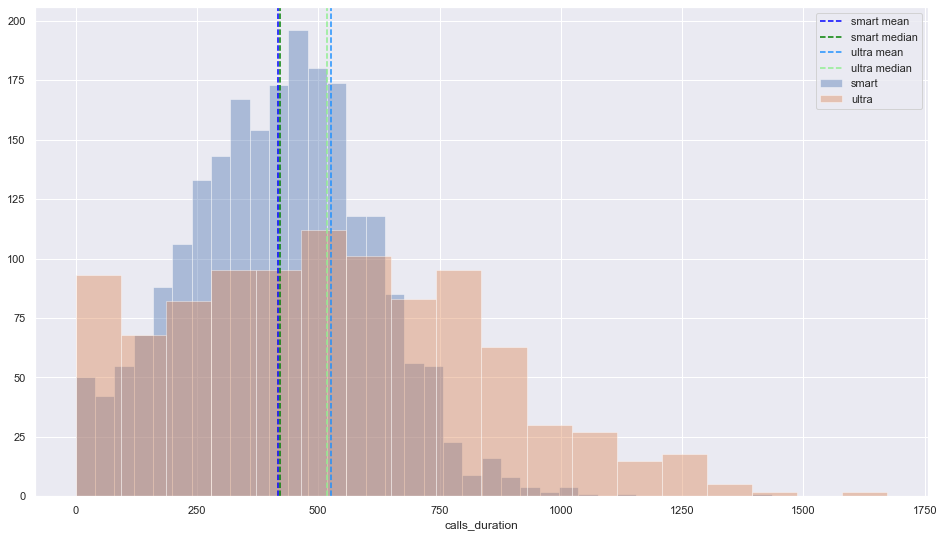

In [36]:
tariff_component_hist('calls_duration', 'minutes_included')

* Распределения визуально похожи на нормальные.
* В распределении абонентов тарифа `ultra` наблюдается больший разброс.
* В среднем абоненты каждого тарифа не выходят за рамки включенных в тариф минут.
* С точки зрения импользования минут на звонки чуть меньше половины всех абонентов тарифа `ultra` хватало бы лимита из тарифа `smart`. Это говорит о том, что возможно абоненты тарифа `ultra` выбрали именно этот тариф не за звонки, а скорее за возможность выхода в интернет (СМС уже не очень популярны).

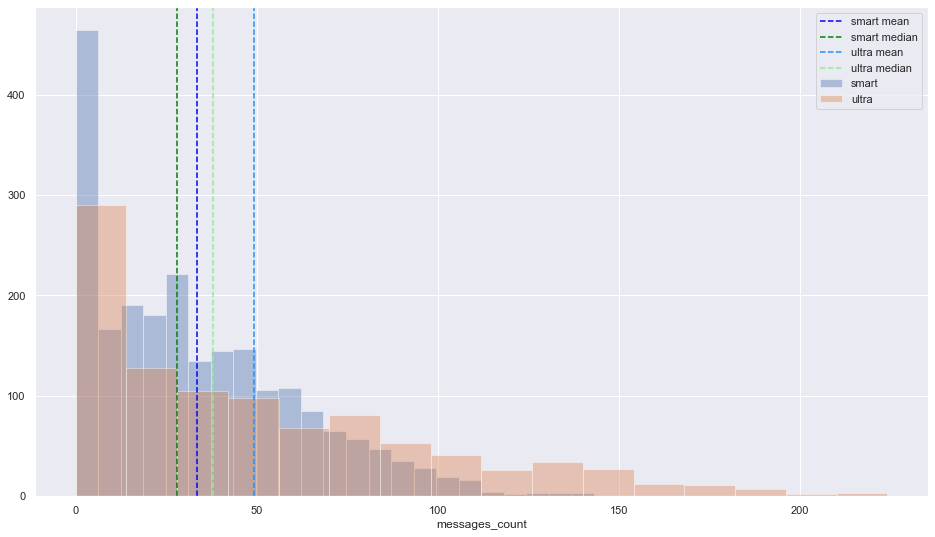

In [37]:
tariff_component_hist('messages_count', 'messages_included')

* Как и предполагалось, СМС не пользуются большой популярностью.
* Только абоненты тарифа `smart` превышают свой лимит по смс.

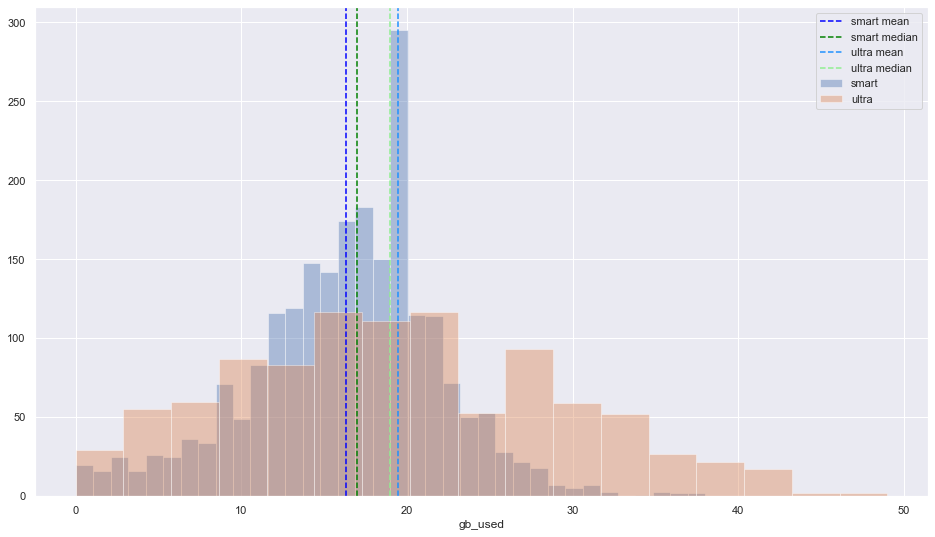

In [38]:
tariff_component_hist('gb_used', 'mb_per_month_included')

* Более половины абонентов тарифа `smart` превышают бесплатный лимит по использованию мобильного интернета.
* Если почти половина абонентов тарифа `ultra` укладываются по звонками в лемит тарифа `smart`, то мы предположили, что эти абоненты тарифа `ultra` выбирают именно этот тариф за интернет. Действительно, есть немало абонентов, кому  не хватает даже лимита по тарифу `ultra`.

# Шаг 4. Проверка гипотез
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

Для проверки первого утверждения сформулируем нулевую и альтернативную гипотезы:
* H0 - средняя выручка пользователей тарифов «Ультра» и «Смарт» равны
* H1 - средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются

Для проверки второго утверждения сформулируем нулевую и альтернативную гипотезы:
* H0 - средняя выручка пользователей из Москвы и других городов равны
* H1 - средняя выручка пользователей из Москвы и других городов различаются

Для проверки этих утверждений необходимо провести тест сравнения средних двух генеральных совокупнсотей. В первом случае две генеральные совокупнсоти - это пользователи тарифов "Смарт" и "Ультра". А во втором случае - жители Москвы и других городов.

Чтобы определиться с методом посмотрим на распределение выручки по абонентам разных тарифов.

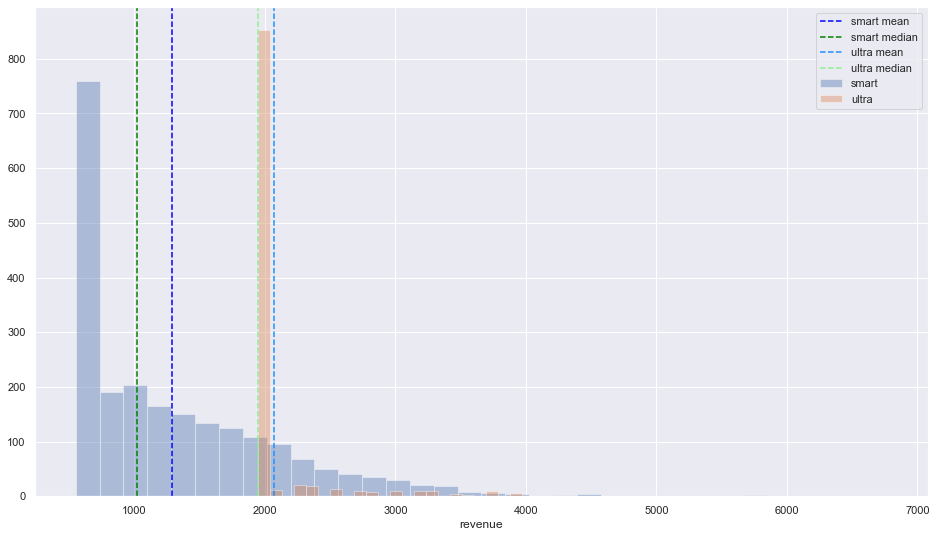

In [39]:
tariff_component_hist('revenue', 0)

Как можно заметить у большинства пользователей тарифа "Смарт" расходы превышают абонентскую плату. Что не скажешь о пользователях тарифа "Ультра". Это указывает на то, что в генеральных совокупностях отличается дисперсия, поэтому это необходимо учесть.

In [40]:
smart_moscow_revenue = data.query('city == "Москва"')['revenue']
smart_other_region_revenue = data.query('city != "Москва"')['revenue']
alpha = .05

results = st.ttest_ind(smart_moscow_revenue, smart_other_region_revenue, equal_var = False)

print('Средняя выручка с пользователя тарифа "Смарт" из Москвы', round(smart_moscow_revenue.mean(), 2))
print('Средняя выручка с пользователя тарифа "Смарт" НЕ из Москвы', round(smart_other_region_revenue.mean(), 2))
print()
print('p-значение: ', results.pvalue)
print()

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу.')
else:
    print("Не получилось отвергнуть нулевую гипотезу.")
    print('Можно считать, что средняя выручка, получаемая с абонентов г. Москва, не отличается статистически значимо от средней выручки по всем другим регионам.')

Средняя выручка с пользователя тарифа "Смарт" из Москвы 1546.71
Средняя выручка с пользователя тарифа "Смарт" НЕ из Москвы 1524.73

p-значение:  0.5216952110000278

Не получилось отвергнуть нулевую гипотезу.
Можно считать, что средняя выручка, получаемая с абонентов г. Москва, не отличается статистически значимо от средней выручки по всем другим регионам.


In [41]:
smart_revenue = data.query('tariff == "smart"')['revenue']
ultra_revenue = data.query('tariff == "ultra"')['revenue']
alpha = .05

results = st.ttest_ind(smart_revenue, ultra_revenue, equal_var = False)

print('Средняя выручка с пользователя тарифа "Смарт"', round(smart_revenue.mean(), 2))
print('Средняя выручка с пользователя тарифа "Ультра"', round(ultra_revenue.mean(), 2))
print()
print('p-значение: ', results.pvalue)
print()

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу.')
    print('Средняя выручка с пользователя тарифа "Ультра" выше.')
else:
    print('Не получилось отвергнуть нулевую гипотезу, H0.')
    print('Вероятнее всего выручки можно считать равными.')

Средняя выручка с пользователя тарифа "Смарт" 1289.64
Средняя выручка с пользователя тарифа "Ультра" 2070.03

p-значение:  1.927011394420941e-250

Отвергаем нулевую гипотезу.
Средняя выручка с пользователя тарифа "Ультра" выше.


### Краткий вывод по по проверке гипотез.
* Средняя выручка пользователей из Москвы и других городов равны.
* Средняя выручка с пользователя тарифа "Ультра" выше.


# ВЫВОД

Из формального теста следует, что средняя выручка с абонента тарифа "Ультра" выше. На первый взгляд этого вывода может быть достаточно для того, чтобы направить деньги на рекламу именно на тарифа "Ультра". В среднем абонент тарифа "Ультра" приносит больше выручки, чем абонент тарифа "Смарт", но вероятнее всего и привлечь абонента тарифа "Ультра" будет сложнее (например, потому что просто нет много людей способных оплачивать такой дорогой тариф). Таким образом, для принятия окончательного решения нужно понимать не только сколько принесет новый абонент тарифа, но и сколько средств необходимо потратить на его привлечение. Если мы исходим из предположения, что на одну и ту же сумму рекламного бюджета мы привлечем одинаковео количество абонентов любого из двух тарифов, то однозначно надо вкладывать в рекламу тарифа "Ультра", но есть опасения, что привлекать такого абонента дороже (т. е. за одну и ту де сумму рекламного бюджета мы привлечем абонентов тарифа "Ультра" намного меньше, чем абонентов тарифа "Смарт").

Таким образом, при условии равной эффективности рекламных кампаний с точки зрения количества привлеченных клиентов можно сделать вывод, что стоит вкладываться в рекламу тарифа "Ультра".